In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from scipy import interp


warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention that missings values = -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()

####### Nominal #######
all_data = pd.concat([all_data,
                                pd.get_dummies(all_data['SHIPPING_MODE'], prefix='SHIPPING_MODE'),
                                pd.get_dummies(all_data['SELLER_COUNTRY'], prefix='SELLER_COUNTRY'),
                                pd.get_dummies(all_data['PRODUCT_TYPE'], prefix='PRODUCT_TYPE'),
                                pd.get_dummies(all_data['PRODUCT_FAMILY'], prefix='PRODUCT_FAMILY'),
                                pd.get_dummies(all_data['BUYER_DEPARTMENT'], prefix='BUYER_DEPARTMENT'),
                                pd.get_dummies(all_data['SELLER_DEPARTMENT'], prefix='SELLER_DEPARTMENT')
                           ],
                          axis=1)

#######Ordinal #######
all_data['PRICECLUB_STATUS'] = all_data['PRICECLUB_STATUS'].map( {'MISSING':0,'UNSUBSCRIBED':1, 'REGULAR': 2, 'SILVER':3, 'GOLD':4, 'PLATINUM':5}).astype(np.int16)
all_data['SHIPPING_PRICE'] = all_data['SHIPPING_PRICE'].map( {'MISSING':0,'<1':1, '1<5': 2, '5<10':3, '10<20':4, '>20':5}).astype(np.int16)
all_data['WARRANTIES_PRICE'] = all_data['WARRANTIES_PRICE'].map( {'NON_WARRANTIES':0, '<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5}).astype(np.int16)
all_data['PURCHASE_COUNT'] = all_data['PURCHASE_COUNT'].map( {'MISSING':0,'<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5, '>500':6}).astype(np.int16)
all_data['SELLER_SCORE_COUNT'] = all_data['SELLER_SCORE_COUNT'].map( {'MISSING':0,'<100':1, '100<1000': 2, '1000<10000':3, '10000<100000':4, '100000<1000000':5}).astype(np.int16)
all_data['ITEM_PRICE'] = all_data['ITEM_PRICE'].map( {'MISSING':0,'<10':1, '10<20': 2, '20<50':3, '50<100':4, '100<500':5, '500<1000':6, '1000<5000':7, '>5000':8}).astype(np.int16)

# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)
all_data = all_data.drop(['WARRANTIES_FLG'],  axis=1)

# REMOVAL OF FEATURES THAT WERE ENCODED
all_data = all_data.drop(['SHIPPING_MODE'],  axis=1)
all_data = all_data.drop(['SELLER_COUNTRY'],  axis=1)
all_data = all_data.drop(['PRODUCT_FAMILY'],  axis=1)
all_data = all_data.drop(['PRODUCT_TYPE'],  axis=1)
all_data = all_data.drop(['BUYER_DEPARTMENT'],  axis=1)
all_data = all_data.drop(['SELLER_DEPARTMENT'],  axis=1)

# Machine Learning

In [9]:
def plot_roc_curve(y, y_predicted, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
   
    #################################### Calcul of ROC by class ####################################
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #################################### Calcul of ROC micro ####################################
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #################################### Calcul of ROC macro ####################################
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) # First aggregate all false positive rates

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes # Finally average it and compute AUC

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    ################################### Plot  ###################################
    l1='micro-average (area = {0:0.2f})'.format(roc_auc["micro"])
    l2='macro-average (area = {0:0.2f})'.format(roc_auc["macro"])

    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"], label=l1, color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label=l2, color='navy', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],  lw=2, label='{0} (area = {1:0.2f})'.format(target_vectoriser(i), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

ONLY NUMERICAL FEATURES

f1_score:       0.18937050715881484 
roc_auc_score:  0.6216084755083784 

                          precision    recall  f1-score   support

                       -       0.40      0.72      0.52      3059
                 DAMAGED       0.14      0.05      0.08      1159
               DIFFERENT       0.06      0.04      0.05       836
                    FAKE       0.00      0.50      0.01        24
            NOT_RECEIVED       0.26      0.02      0.04      2831
SELLER_CANCEL_POSTERIORI       0.26      0.08      0.13      2698
               UNDEFINED       0.09      0.08      0.09       790
              WITHDRAWAL       0.13      0.12      0.12      1365

             avg / total       0.25      0.22      0.19     12762



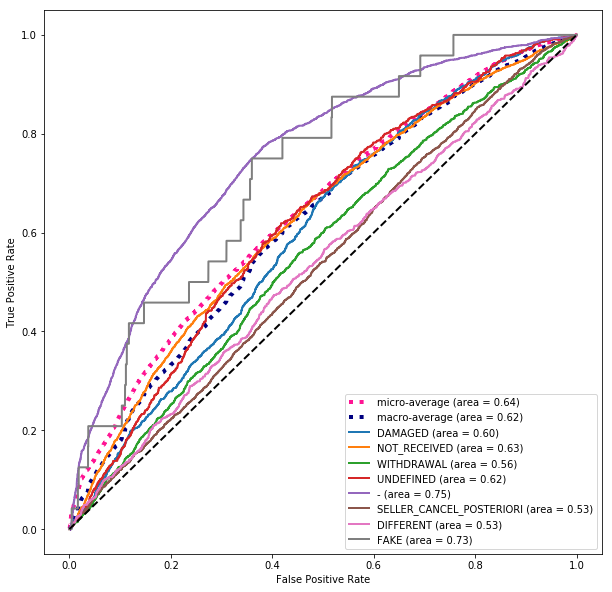

Wall time: 1.05 s


In [10]:
%%time
numerical_features = all_data.get(['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE']).copy()

X_train, X_test, y_train, y_test = train_test_split(numerical_features.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
w=compute_sample_weight(class_weight='balanced', y=y_train) 
imputer = Imputer(strategy='mean', missing_values=-1) 

#fill of NaN
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = RobustScaler()
scaler.fit(X_train_imputed)
X_train_transformed =scaler.transform(X_train_imputed)
X_test_transformed = scaler.transform(X_test_imputed)

classifier =  LogisticRegression(solver='lbfgs', multi_class='multinomial')
classifier.fit(X_train_transformed, y_train, sample_weight=w)
y_test_predicted = classifier.predict(X_test_transformed)

y_test_predicted_label = target_vectoriser(y_test_predicted)
y_test_label = target_vectoriser(y_test)
y_test_binary = lb.fit_transform(y_test)
y_test_predicted_proba = classifier.predict_proba(X_test_transformed)
    
print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'), '\nroc_auc_score: ', metrics.roc_auc_score(lb.fit_transform(y_test), y_test_predicted_proba, average='weighted'), '\n')
print(classification_report(y_test_label, y_test_predicted_label))
plot_roc_curve(y_test_binary, y_test_predicted_proba, target_label.shape[0])

In [11]:
matrix=pd.crosstab(y_test_label, y_test_predicted_label, rownames=['Current'], colnames=['Predicted'])
matrix['Total']= matrix.sum(axis=1)
matrix.loc["Total"]=matrix.sum()
matrix

Predicted,-,DAMAGED,DIFFERENT,FAKE,NOT_RECEIVED,SELLER_CANCEL_POSTERIORI,UNDEFINED,WITHDRAWAL,Total
Current,,,,,,,,,
-,2193,61,101,218,36,157,64,229,3059
DAMAGED,345,63,56,378,33,85,82,117,1159
DIFFERENT,345,31,37,224,20,69,48,62,836
FAKE,3,1,2,12,0,4,1,1,24
NOT_RECEIVED,846,113,130,1084,69,141,172,276,2831
SELLER_CANCEL_POSTERIORI,1064,97,163,641,42,225,187,279,2698
UNDEFINED,197,27,41,272,36,61,65,91,790
WITHDRAWAL,443,70,76,377,30,115,95,159,1365
Total,5436,463,606,3206,266,857,714,1214,12762


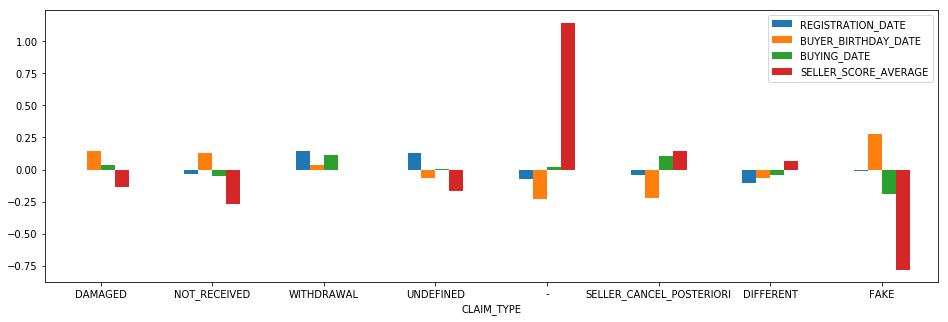

In [12]:
d = pd.DataFrame({'REGISTRATION_DATE': classifier.coef_[:,0],'BUYER_BIRTHDAY_DATE': classifier.coef_[:,1],'BUYING_DATE': classifier.coef_[:,2],'SELLER_SCORE_AVERAGE': classifier.coef_[:,3]})
d['CLAIM_TYPE'] = target_label
d=d.set_index('CLAIM_TYPE')

d.plot.bar(rot=0, figsize=(16,5));

MORE FEATURES

In [13]:
numerical_features=list()
for x in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE', 'PRICECLUB_STATUS', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PURCHASE_COUNT', 'SELLER_SCORE_COUNT', 'ITEM_PRICE'] : 
    numerical_features.append(all_data.columns.get_loc(x))

def run_classifier(data, scaler, nf):
    X_train, X_test, y_train, y_test = train_test_split(data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    imputer = Imputer(strategy='mean', missing_values=-1) 

    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)
    X_test_imputed = imputer.transform(X_test)
 
    X_train_transformed = X_train_imputed
    X_train_transformed[:,nf] = scaler.fit_transform(X_train_imputed[:,nf])
    X_test_transformed = X_test
    X_test_transformed[:,nf] = scaler.transform(X_test_imputed[:,nf])

    classifier =  LogisticRegression(solver='lbfgs', multi_class='multinomial')
    classifier.fit(X_train_transformed, y_train, sample_weight=w)
    y_test_predicted = classifier.predict(X_test_transformed)
    y_test_predicted_proba = classifier.predict_proba(X_test_transformed)

    y_test_predicted_label = target_vectoriser(y_test_predicted)
    y_test_label = target_vectoriser(y_test)
    y_test_binary = lb.fit_transform(y_test)

    print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'), '\nroc_auc_score: ', metrics.roc_auc_score(lb.fit_transform(y_test), y_test_predicted_proba, average='weighted'), '\n')
    print(classification_report(y_test_label, y_test_predicted_label))    
    plot_roc_curve(y_test_binary, y_test_predicted_proba, target_label.shape[0])

f1_score:       0.37743355433855846 
roc_auc_score:  0.7455164452640641 

                          precision    recall  f1-score   support

                       -       0.59      0.71      0.64      3059
                 DAMAGED       0.20      0.21      0.20      1159
               DIFFERENT       0.14      0.25      0.18       836
                    FAKE       0.01      0.62      0.03        24
            NOT_RECEIVED       0.52      0.31      0.39      2831
SELLER_CANCEL_POSTERIORI       0.47      0.26      0.33      2698
               UNDEFINED       0.18      0.22      0.20       790
              WITHDRAWAL       0.24      0.21      0.22      1365

             avg / total       0.42      0.37      0.38     12762



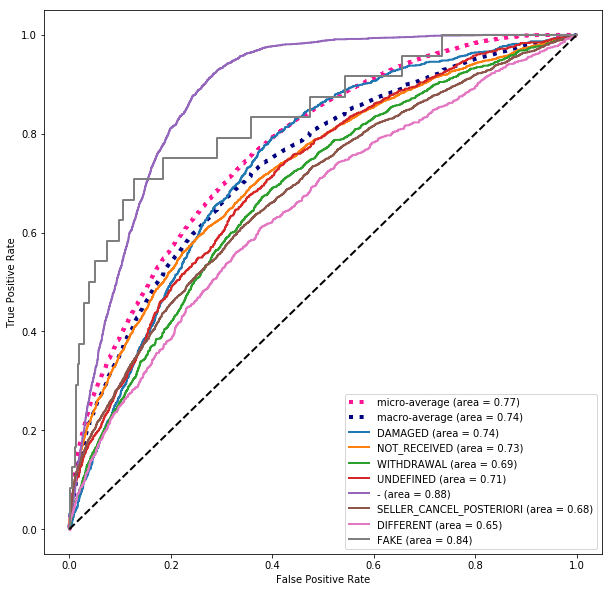

Wall time: 12.9 s


In [14]:
%%time
run_classifier(all_data, StandardScaler(), numerical_features)

f1_score:       0.37747027614906326 
roc_auc_score:  0.7455196561709259 

                          precision    recall  f1-score   support

                       -       0.59      0.70      0.64      3059
                 DAMAGED       0.20      0.21      0.21      1159
               DIFFERENT       0.14      0.25      0.18       836
                    FAKE       0.01      0.62      0.03        24
            NOT_RECEIVED       0.52      0.31      0.39      2831
SELLER_CANCEL_POSTERIORI       0.47      0.26      0.33      2698
               UNDEFINED       0.18      0.23      0.20       790
              WITHDRAWAL       0.24      0.21      0.23      1365

             avg / total       0.42      0.37      0.38     12762



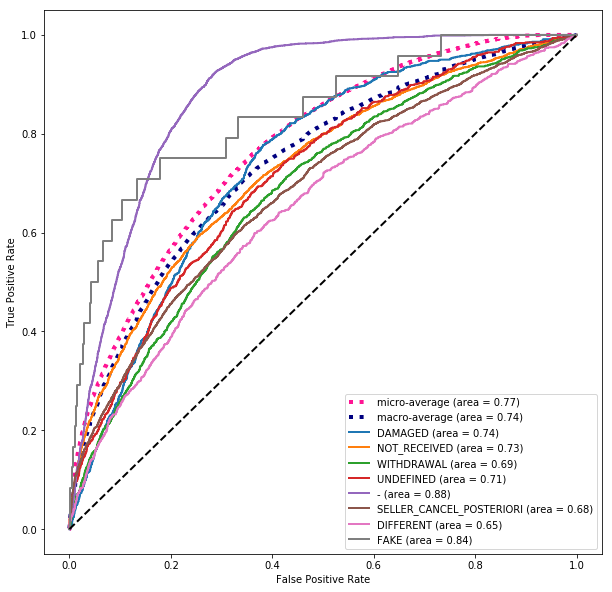

Wall time: 11.6 s


In [15]:
%%time
run_classifier(all_data, MinMaxScaler(), numerical_features)

f1_score:       0.37827597219504966 
roc_auc_score:  0.7456539214776338 

                          precision    recall  f1-score   support

                       -       0.59      0.71      0.64      3059
                 DAMAGED       0.20      0.21      0.21      1159
               DIFFERENT       0.14      0.25      0.18       836
                    FAKE       0.01      0.62      0.03        24
            NOT_RECEIVED       0.52      0.31      0.39      2831
SELLER_CANCEL_POSTERIORI       0.47      0.26      0.33      2698
               UNDEFINED       0.18      0.22      0.20       790
              WITHDRAWAL       0.24      0.21      0.22      1365

             avg / total       0.42      0.37      0.38     12762



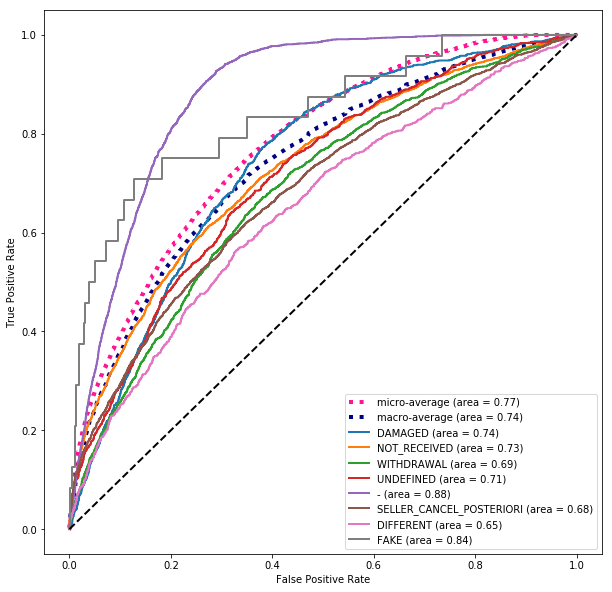

Wall time: 11.1 s


In [16]:
%%time
run_classifier(all_data, RobustScaler(), numerical_features)

f1_score:       0.32213292940834254 
roc_auc_score:  0.7099673131096301 

                          precision    recall  f1-score   support

                       -       0.49      0.60      0.54      3059
                 DAMAGED       0.19      0.19      0.19      1159
               DIFFERENT       0.12      0.25      0.16       836
                    FAKE       0.01      0.58      0.02        24
            NOT_RECEIVED       0.48      0.23      0.31      2831
SELLER_CANCEL_POSTERIORI       0.50      0.21      0.29      2698
               UNDEFINED       0.17      0.23      0.19       790
              WITHDRAWAL       0.22      0.20      0.21      1365

             avg / total       0.39      0.31      0.32     12762



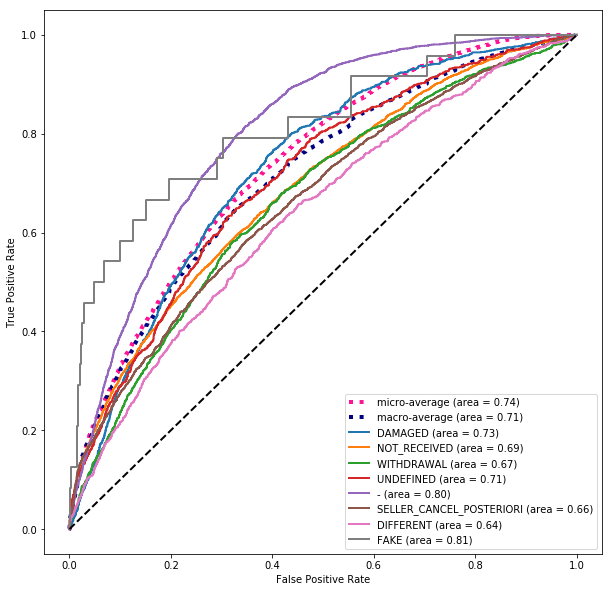

Wall time: 10.9 s


In [17]:
%%time
run_classifier(all_data, Normalizer(), numerical_features)